# Configuration (Hyperparameters)
Since this is a notebook, it makes a lot of sense to play around with parameters defined just above where they are used, to enable fast iteration. However, it is also much easier to manage configuration in one place. 
Set `use_local = False` in order to use the parameters listed in this top conifg.
Set `use_local = True` to rely on parameters defined throughout this notebook.

In [373]:
use_local = True

# Path to images for training and evaluation (this makes it easier to try on different datasets)
passing_images_dir = r"C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld\Fail"
anomaly_images_dir = r"C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld\Pass"

# Load External Dependencies
TODO: 
- Environment: (Consider scripting this in, esp. if I move it into colab)
    - All the imports should be in this section
- Data: move all paths up here, and a test to ensure the datasets load
    - Training Data: I won't be making this data public. There is too much, and most of it is not mine to share.
        - Custom Data: I highly encourage checking how well this generalizes!
    - Evaluation Data: I will include a couple of sample images in the repo, so that anyone can load the model and run with it
- Trained Models: 
    - TODO: I need to add these in a convenient way
        -This was created as a proof of concept, so I've got a mess of dependencies and local paths to clean up
- Re-think some naming conventions throughout this doc
- clean up the display images (lots of redundancy that was helpful during dev, but confusing now)
    - improve labels
- improve the TF implementations
    - could be a lot cleaner with built in train and eval functions

In [374]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import glob
import time
import random

In [375]:
def validate_image_dir(src_dir, rich_print=True):
    """
    Purpose: Perform basic validation that the directory is valid.
    Considered valid if the directory contains at least 1 file. 
    Does NOT check extensions to verify files are images
    
    inputs:
        src_dir (string): directory to validate
        rich_print (bool): Whether to print a msg summarizing validation
    """
    good_image_paths = glob.glob(src_dir + '\*' )
    assert(len(good_image_paths) != 0)
    if rich_print:
        print(f"Found {len(good_image_paths)} files in in directory:\n{src_dir}")

if use_local:
    validate_image_dir(passing_images_dir)
    validate_image_dir(anomaly_images_dir)

Found 147 files in in directory:
C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld\Fail
Found 146 files in in directory:
C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld\Pass


All external dependencies should be loaded (so hopefully it's smooth sailing from here).

# Image Processing Tools

TODO: Consider Moving "Tools" into 1 or more separate python files, and importing

In [376]:
def binarize(image, thresh):
    """ 
    Creates a copy of the images, with binary thresholding. The return image will set
    pixels above 'thresh' to 'value'. 
    Original image will not be modified.
    
    Inputs:
        image: src image that threshold image will be based on
        thresh: image will be thresholded based on this value.
        value: All pixels below the thresh are set to 0, pixels above the thresh are set to value
        
    return:
        image: The return image will be a binary threshold of the input image, based on thresh
    """
    image = image.copy()
    
    idx = (image[:,:] < thresh)
    image[idx] = 0
    
    idx = (image[:,:] > thresh)
    image[idx] = 1
    
    return image

In [377]:
def zero_outside_range(image, limits):
    image = image.copy()
    lower, upper = limits
    
    if lower:
        idx = (image[:,:] < lower)
        image[idx] = 0
        
    if upper:
        idx = (image[:,:] > upper)
        image[idx] = 0
    
    return image

In [378]:
# Only used for graphing at the moment - nifty, but it should only be called in the graph method, and 
# I should just be moving the viewing area, not changing the data
def limit(image, limits):
    image = image.copy()
    lower, upper = limits
    
    if lower:
        idx = (image[:,:] < lower)
        image[idx] = lower
        
    if upper:
        idx = (image[:,:] > upper)
        image[idx] = upper
    
    return image

In [379]:
def crop(img, top, bottom, left, right):
    return img[top:bottom, left:right]

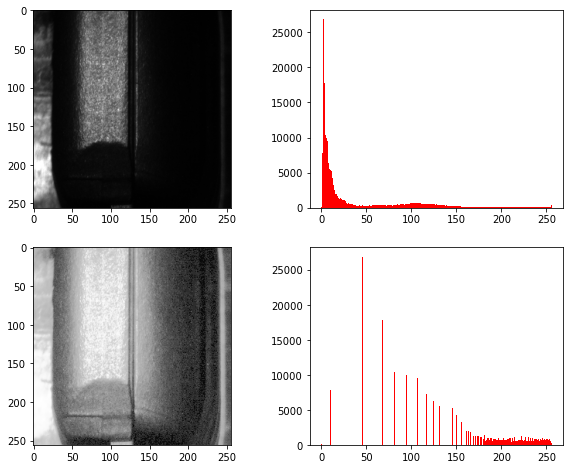

34.919830322265625
132.48060607910156


In [380]:
# Other Links of interest (adaptive threshold and histogram equalization)
# https://en.wikipedia.org/wiki/Adaptive_histogram_equalization
# https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

# Huge thanks to: https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
# Note that we won't bother to record this hist, so we won't be able to restore the original (and that's totally fine)
def equalize_histogram(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf2 = np.ma.filled(cdf_m,0).astype('uint8')
    equalized_img = cdf2[img]
    return equalized_img

########## test ###########
# Create Image/Hist
dsize = (256, 256)
index = 5
test_img = [ cv2.resize(cv2.imread(image_path), dsize) for image_path in glob.glob(passing_images_dir + '\*' )[index: index+1]][0]
eq_img = equalize_histogram(test_img)

# Display result
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8) )
ax00, ax01, ax10, ax11 = axes.flatten()

ax00.imshow(test_img)
ax01.hist(test_img.flatten(),256,[0,256], color = 'r')

ax10.imshow(eq_img)
ax11.hist(eq_img.flatten(),256,[0,256], color = 'r')
plt.show()

print(np.mean(test_img))
print(np.mean(eq_img))

# TODO:
- Arguably too simple of a function...I think it just makes things more confusing. consider removing

In [381]:
def normalize_images(image):
    return (image / 256.)

In [382]:
# def restore_normalized_images(image):
#     return (image * 256.)

# Display Tools

In [383]:
def show_image_grid(images, labels = None, intensity_range = None, im_size=1):
    """
    Purpose:
        Helper function for displaying multiple images together in a grid.
    
    Inputs:
        images: A grid of images (list of list of images, or 4D numpy array of [n_rows, n_cols, im_height, im_width].
            The display shape will match the input shape. All rows are expected to be the same length.
        labels: A grid of labels (shape must match images).
        intensity_range: list of [vmin, vmax]
            - This is useful if you wish all plots to use the same intensity scale.
        im_size: This can be used to scale images down. Most useful with 1-4 images, when they tend to scale up.
            - Warning: values >1 will prevent some data from being displayed, because the image grid will be
                       larger than the plot size allotted.
    
    Return: None
    """        
    
    images = np.array(images)
        
    if(len(images.shape) != 4):
        print("Error: Input shape of images is not correct. Ensure input is 4D: n_rows, n_cols, im_height, im_width")
        return False
    
    if(im_size > 1):
        print("*"*100)
        print("Warning: im_size > 1 in call to 'show_image_grid'. Some images may not be displaying. Consider using im_size <= 1.")
        print("*"*100)
    im_size *= 6
    
    n_rows, n_cols, im_height, im_width = images.shape
    
    show_title = True
    if(labels is None):
        show_title = False
        labels = np.zeros((n_rows, n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(im_size*n_cols,im_size*n_rows)) # (20/n_images, 20/n_images))

    axs = np.array(axs).reshape(n_rows, n_cols)
    for ax_row, img_row, label_row in zip(axs, images, labels):
        for ax, img, label in zip(ax_row, img_row, label_row):
            if intensity_range is None:
                ax.imshow(img)
            else:
                ax.imshow(img, vmin = intensity_range[0], vmax = intensity_range[1])

            if(show_title):
                ax.set_title(label)
                ax.title.set_fontsize(3*im_size)
            
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

# Load Images

TODO: Consider moving the function in this section to their own python file (the configuration should stay here though)

In [384]:
def Read_and_preprocess_images(src_dir, dsize = (256, 256)):
    """
    Reading and preprocessing combined in one method because we're avoiding generators at the moment, and 
    some of the input images may be large. By reading and scaling down immediately, we can keep memory
    manageable. Long-term, I may convert to generator expressions, but that's really not the point of this
    excercise.
    """
    print('Loading and pre-processing images...')
    t = time.time()
    
    # Read images
    images = [ cv2.resize(cv2.imread(image_path), dsize) for image_path in glob.glob(src_dir + '\*' )] 
    
    # Resize
    images = [cv2.resize(image, dsize) for image in images]
    
    # Grayscale
    images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]
    
    # Histogram Equalization
    images = [equalize_histogram(image) for image in images]
    
    # Normalize (scale into range(0->1))
    images = [image/256. for image in images]
    
    #Convert to numpy array
    images = np.array(images)
     
    print(f"Preprocessing complete in {time.time() - t}s.")
    
    return images

In [385]:
train_images = Read_and_preprocess_images(passing_images_dir)
unfit_images = Read_and_preprocess_images(anomaly_images_dir)

print(train_images.shape)
print(unfit_images.shape)

Loading and pre-processing images...
Preprocessing complete in 8.59700345993042s.
Loading and pre-processing images...
Preprocessing complete in 6.376248836517334s.
(147, 256, 256)
(146, 256, 256)


# TODO:
- Perform Train/Test split
- Rename to nominal / anomalous & train/test
- Use the sample image, rather than carrying the entire data setting and constantly indexing

In [342]:
# Select images to demo in this notebook
nominal_index = random.randrange(0, len(train_images))
nominal_img = train_images[nominal_index]

anomalous_index = random.randrange(0, len(unfit_images))
anomalous_img = unfit_images[anomalous_index]

# Comparing Histograms of nominal / anomalous

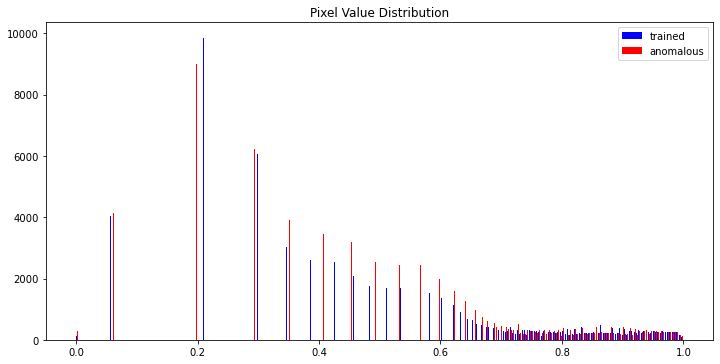

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5) )
fig.tight_layout()

def plot_hist(ax, data, title):
    colors=['blue','red']
    labels=["trained", "anomalous"]
    x_range = np.linspace(0, 1, 256)
    ax.hist(data, x_range, histtype='bar', color=colors, label=labels)
    ax.set_title(title)
    ax.legend(prop={'size': 10})

data = [nominal_img.flatten(), anomalous_img.flatten()]
title = "Pixel Value Distribution"
plot_hist(axes, data, title)
plt.show()

### Visualize data (this is a manual sanity check):
- Types of data:
    - First row is passing data (unwelded - just clean metal).
    - Second row is welded, as our 'anomaly' in this case will be the weld itself.
- Pre-Processing being demonstrated (by column)
    - First column is raw image data, just to show we've read the grayscale images correctly
    - Second column contains normalized images (which should look "flat" in color space)
        - This would not be the best choice of normalization in general, at it greatly increases the decreases the model's robustness to translation. 
        - This tequnique happened to work well on this particular dataset, because of poor lighting/hot spots. I started trying to justify it, but I think I just need to go back and adjust the methodology. It happened to work well here, but generally would not.
    - Third column is a restored image, demonstrating that we've reversed the normalization correctly (it should look identical to the first column

In [16]:
# # Row 1 and 3 should match. Row 2 should be 'flattened in color space, due to the normalization.
# passing_raw = nominal_img
# passing_norm = normalize_images(passing_raw)
# passing_restored = restore_normalized_images(np.expand_dims(passing_norm, 0))

# anomalous_raw = anomalous_img
# anomalous_norm = normalize_images(anomalous_raw)
# anomalous_restored = restore_normalized_images(np.expand_dims(anomalous_norm, 0))

# grid_images = np.array([ [ passing_raw,   passing_norm,   passing_restored[0]   ],
#                          [ anomalous_raw, anomalous_norm, anomalous_restored[0] ] ])


# labels = [["Passing Image (raw)",   "Passing Image (Normalized)",   "Passing Image (Restored)"  ],
#           ["Anomalous Image (raw)", "Anomalous Image (Normalized)", "Anomalous Image (Restored)"] ]

# show_image_grid(grid_images, labels=labels)

# Model
- We won't be regularizing, since we're actually attempted to overfit to some extent

In [17]:
# Note: Default init is glorot_uniform, bias=zeros
model = Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv1", input_shape = (256, 256, 1)),
    layers.MaxPooling2D((2, 2), padding="same", name="pool1"),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv2"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool2"),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv3"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool3"),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv4"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool4"),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv5"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool5"),
    layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same", name="convTrans5"),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans4"),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans3"),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans2"),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans1"),
    layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same", name="Channel_Reducer")
    ])

# Train

TODO: 
    - This section has some nice manual methods...it's just that there's such clean ones already built-in,
consider switching over...It will make: this cleaner, the output cleaner, easier to add callbacks and metrics, etc.
    - Consider adding saving along the way, either periodically, or for best, and maybe add early stopping (with a high-ish patience)

TODO: Isn't this preprocessing? Why do I have it here?

In [18]:
# Optimizer can be reset without resetting entire model (momentum for Adam will reset though)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy())
#                   loss=tf.keras.losses.MeanSquaredError())

In [19]:
# keras.utils.plot_model(model,
#                        show_shapes=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 256, 256, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 32)      9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 32)        9248      
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv4 (Conv2D)               (None, 32, 32, 32)        9

In [69]:
tf.config.experimental_run_functions_eagerly(True)
epochs = 75 # 5-8 epochs to show any intelligence, at least 30 for decent results, probably 75 for "good" numbers
batch_size = 32
# train_length = len(train_images) // 32 # num of mini-batches per epoch (why don't they just ask batch_size?)
# test_length = 2
# print("Mean: ", np.mean(train_images))
training_hist = model.fit(x = np.expand_dims(train_images, -1),
                          y = np.expand_dims(train_images, -1),
                          epochs=epochs,
                          batch_size = batch_size,
                          shuffle=True)
#                               steps_per_epoch= train_length) # , # len(train_images) // batch_size),
#                               validation_data=test_data_gen,
#                               validation_steps= test_length) # len(test_images) // batch_size)

Epoch 1/75
5/5 [==============================] - 18s 4s/step - loss: 0.6071
Epoch 2/75
5/5 [==============================] - 18s 4s/step - loss: 0.6059
Epoch 3/75
5/5 [==============================] - 18s 4s/step - loss: 0.6048
Epoch 4/75
5/5 [==============================] - 18s 4s/step - loss: 0.6036
Epoch 5/75
5/5 [==============================] - 19s 4s/step - loss: 0.6027
Epoch 6/75
5/5 [==============================] - 18s 4s/step - loss: 0.6019
Epoch 7/75
5/5 [==============================] - 18s 4s/step - loss: 0.6010
Epoch 8/75
5/5 [==============================] - 18s 4s/step - loss: 0.6009
Epoch 9/75
5/5 [==============================] - 18s 4s/step - loss: 0.5998
Epoch 10/75
5/5 [==============================] - 18s 4s/step - loss: 0.5989
Epoch 11/75
5/5 [==============================] - 19s 4s/step - loss: 0.5980
Epoch 12/75
5/5 [==============================] - 18s 4s/step - loss: 0.5972
Epoch 13/75
5/5 [==============================] - 19s 4s/step - loss: 0.

# Save and Load

In [70]:
# model_name = os.path.join("models/", "trained_model")
# model.save(model_name) # I've got a decent model saved already

In [71]:
# model = tf.keras.models.load_model(model_name)
# model.summary()

# Apply model and post-process results

In [72]:
# def build_output_images(model, images):
#     """
#     This runs the forward pass of the model on a set of images. Normalization, shaping, and 
#     other details are handled internally
    
#     Inputs:
#         model: The trained model
#         images: a list of images, matching the shape of the model input
#         mean_image: Average of all images in the dataset (used for normalization)
        
#     Return:
#         Auto-Encoded image. This should preserve a large amount of data from the "passing" images,
#         while losing most of the anomalous features.
#     """
    
#     # Normalize
#     print("Building output images:")
#     print("Normalizing...", end="")
#     images = normalize_images(images)
#     # Reshape
#     print(f"Reshaping to {images.shape}...", end="")
#     shape = images.shape
#     n_channels = 1
#     images = images.reshape(shape[0], shape[1], shape[2], n_channels)

#     # model (code and decode)
#     print("Modeling...", end="")
#     images = model(images)
    
#     # Reverse normalization, restoring original
#     print("Restoring...", end="")
#     images = np.array(images[:,:,:,0])
#     images = restore_normalized_images(images)
#     print("Finished")
    
#     return images

In [73]:
# print('Reconstructing trained images...')
# reconstructions = build_output_images(model, train_images) 

# print('\nReconstructing unfit images')
# unfit_reconstructions = build_output_images(model, unfit_images) 

In [74]:
# model.predict(np.expand_dims(np.expand_dims(nominal_img, 0), -1).shape)

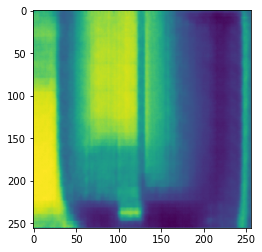

In [75]:
def predict(model, pred_image):
    """
    Just calls model / model.predict on a single image. Just hiding the batch dimension
    for code clarity.
    """
    im_with_dims = np.expand_dims(np.expand_dims(pred_image, 0), -1)
    return model.predict(np.expand_dims(im_with_dims, -1))[0,:,:,0]

# Test
plt.imshow(predict(model, nominal_img))

TODO:
- Looking back at this, the reconstruction picks up 2 things:
    - All high frequency information (makes sense, since my resizing/pooling destroys that anyways)
    - All unique features (eg: the welds)
- Consider leveraging the fact that all high frequency information is detected...
    - maybe pre-process with a low-pass filter(or just resize down to 256 for a similar effect)
    - I'm already doing an erode+dilate, but it's post-processing, and not quite the right way to ignore noise
- Again, using 4 samples, which was nice in dev, but kind of confusing to anybody else reading through now

## Visualize Sample Image

In [76]:
def find_loss_image(image1, image2): 
    height, width = image1.shape
    loss_image = tf.losses.mean_squared_error(image1.reshape(height, width, 1), image2.reshape(height, width, 1)).numpy()
    return loss_image

In [77]:
# Filter out salt and pepper noise
# This model downsamples, losing most the high frequency components...so a little denoising is needed
# This is a quick way to do that
def remove_salt_and_pepper_noise(image, kernel_dims=(3,3), iterations=1):
    kernel = np.ones(kernel_dims, np.uint8)
    
    eroded = cv2.erode(image, kernel, iterations=iterations)
    smoothed = cv2.dilate(eroded, kernel, iterations=iterations)
    
    return smoothed


In [78]:
# # Image Processing Pipeline
# class CropDims:
#     def __init__(self, top, bottom, left, right):
#         self.top = top
#         self.bottom = bottom
#         self.left = left
#         self.right = right

In [79]:
# def process_images(images, crop_dims=None, smoothing_kernel=None):
#     """
#     """
#     if type(images) == list:
#         images = np.array(images)
#         print(f"Shape of images: {images.shape}")
        
#     rebuilt_images = build_output_images(model, images) 
    
#     if crop_dims:
#         c = crop_dims
#         images = np.array([crop(image, c.top, c.bottom, c.left, c.right) for image in images])
#         rebuilt_images = np.array([crop(image, c.top, c.bottom, c.left, c.right) for image in rebuilt_images])
    
#     loss_images = [find_loss_image(image, rebuilt) for image, rebuilt in zip(images,rebuilt_images)]
#     return (images, rebuilt_images, loss_images)

In [80]:
# crop_dims = CropDims(0,255,50,-25)
# thresh = 8000


# TODO: Denoising improvements
- Could try a connected component search, deleting all clusters < 10 or so pixels
- could try this builtin cv2 func: new = cv2.fastNlMeansDenoising(trained_loss[0])

# Demonstrate key feature extraction with loss function
- Notably, there were a few other tequniques that worked well, and that I would have investigated more if this project had continued:
    - using division (which scales for brightness quite well)
    - absdiff (basically MAE)
- I also played with dynamic thresholding a bit, but in the end, I couldn't be sure my thresholds would generalize, because noise distributions might be different; however, for this application, the snippet below worked well.
```
trained_loss_flat = sorted(trained_loss[0].flatten())
thresh = trained_loss_flat[-10]
print("Thresh", thresh)
```

(256, 256) (256, 256) (256, 256)


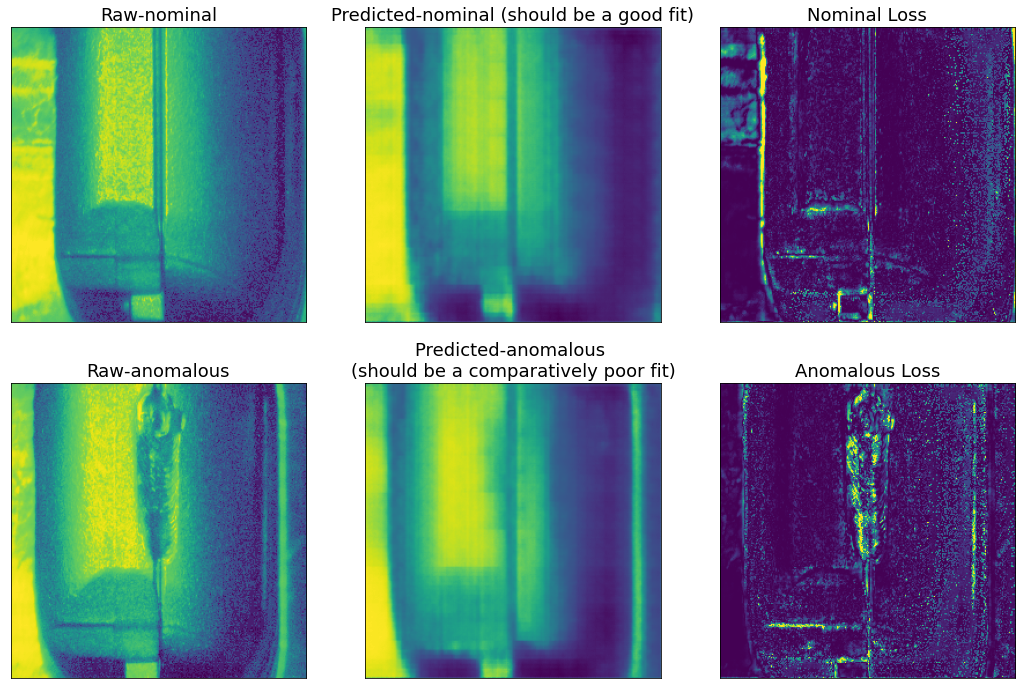

In [344]:
pred_nom_img = predict(model, nominal_img)
nom_loss = find_loss_image(nominal_img, pred_nom_img)

pred_anom_img = predict(model, anomalous_img)
anom_loss = find_loss_image(anomalous_img, pred_anom_img)



label_grid = [["Raw-nominal", "Predicted-nominal (should be a good fit)", "Nominal Loss"],
             ["Raw-anomalous", "Predicted-anomalous \n(should be a comparatively poor fit)", "Anomalous Loss"]]
print(nominal_img.shape, pred_nom_img.shape, nom_loss.shape)
# Sanity check to make sure the images are sensible
y_max = 1
image_grid = np.array([[limit(nominal_img, (None, y_max)),
                        limit(pred_nom_img, (None, y_max)), 
                        limit(nom_loss, (None, y_max/20.))], 
                       [limit(anomalous_img, (None, y_max)), 
                        limit(pred_anom_img, (None, y_max)), 
                        limit(anom_loss, (None, y_max/20.))]])
show_image_grid(image_grid, label_grid)

In [234]:
# # TEMP : Testing
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,12) )
# ax0, ax1 = axes.flatten()
# # fig.tight_layout()

# def plot_hist(ax, data, title):
#     colors=['blue','red']
#     labels=["original", "rebuilt"]
#     x_range = 30 # np.linspace(0, 10e-20, 30)
#     ax.hist(data, x_range, histtype='bar', color=colors, label=labels)
# #     title = (f"{np.min(data[0])}, {np.max(data[0])}")
#     ax.set_title(title)
#     ax.legend(prop={'size': 10})


# data = [nominal_img.flatten(), pred_nom_img.flatten()]
# title = "Trained original vs rebuilt"
# plot_hist(ax0, data, title)

# data = [anomalous_img.flatten(), pred_anom_img.flatten()]
# title = "Weld original vs rebuilt"
# plot_hist(ax1, data, title)

# plt.show()

In [235]:
# We want to demonstrate that the histograms look different, and that by focusing in on certain ranges,
# we can create a metric that clearly distinguishes between distributions

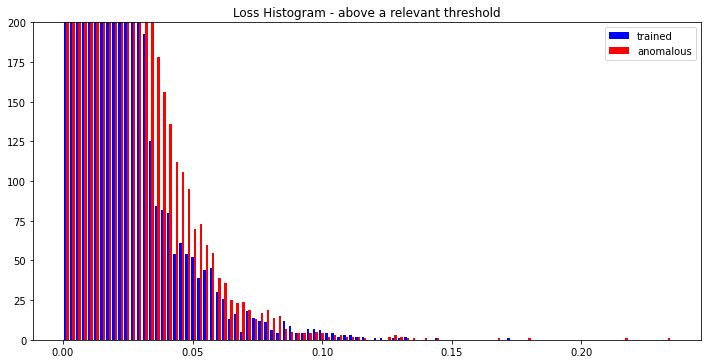

In [236]:
# Plot
# Reference: 
# https://matplotlib.org/2.0.2/examples/statistics/histogram_demo_multihist.html
# https://matplotlib.org/stable/plot_types/stats/hist2d.html?highlight=y%20range

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5) )
# ax0, ax1 = axes.flatten()
ax1 = axes 

fig.tight_layout()
data = [nom_loss.flatten(), anom_loss.flatten()]

colors = ['blue', 'red']
labels = ["trained", "anomalous"]

bins = 100 # np.linspace(xmin, xmax, 30)
ax1.hist(data, bins, histtype='bar', color=colors, label=labels)
# ax1.hist(data, np.linspace(thresh/2, thresh, 30), histtype='bar', color=colors, label=labels)
ax1.set_title('Loss Histogram - above a relevant threshold')
ax1.legend(prop={'size': 10})
# ax1.set(xlim=(xmin, xmax))
ax1.set(ylim=(0, 200))

plt.show()

In [237]:
def denoise(bin_image, min_cluster_size = 5):
    """
    Runs in O(n), where n is the number of pixels in the image.
    I explored some other tools, like erode / dilate, and a few others, but this is working well for now.
    """
    height,width = bin_image.shape #256, 256
    image = bin_image.copy().flatten() # Create a copy (so we don't mess up the original)

    # initialize the visited array (0 for unvisited, -1 for unvisitable, aka bin_image is already 0 there)
    UNEXPLORED = -1
    IMAGE_0 = -2
    visited = np.ones(image.shape)*IMAGE_0# nothing explored yet
    idx = (image[:] != 0)
    visited[idx] = UNEXPLORED

    for search_index in range(image.shape[0]):
        # print(f"{search_index}/{image.shape[0]}")
        frontier = set([search_index]) # initialize with current item
        this_cluster = []
        pixels_in_cluster = 0
        while frontier:
            # print(f"Frontier: {frontier}")
            pixel_index = frontier.pop()
            if visited[pixel_index] == UNEXPLORED:
                visited[pixel_index] = search_index # set the group ID of this pixel to the index that started this DFS
                pixels_in_cluster += 1

                # Add the graph's edges
                if pixel_index >= width:  # up
                    frontier.add(pixel_index - width)
                if pixel_index < width * (height - 1):  # down
                    frontier.add(pixel_index + width)
                if pixel_index % width != 0:  # left
                    frontier.add(pixel_index - 1)
                if pixel_index % width != (width - 1):  # right
                    frontier.add(pixel_index + 1)

                this_cluster.append(pixel_index)

        if len(this_cluster) < min_cluster_size:
            image[this_cluster] = 0

    return image.reshape(height,width)

In [302]:
# TODO: we'll see with the new model, but probably...
#    change thresh ranges
#    Change denoiser (kernel_dims won't be a hyperparameter anymore)
def post_process(pre_img, predicted_im, thresh, min_pixels_per_cluster): 
    loss_im = find_loss_image(pre_img, predicted_im)
    bin_img = binarize(loss_im, thresh)
#     denoised_image = remove_salt_and_pepper_noise(bin_img, kernel_dims)
    denoised_image = denoise(bin_img, min_pixels_per_cluster)
    return denoised_image

In [358]:
thresh = 0.03
min_pixels_per_cluster = 25

nominal_index: 51
anomalous_index: 123
Loss on trained image: 0.0005
Loss on unfit image: 0.0181
0.007232666015625: Unfit image missed 33.89 times as much information.
0.19473276


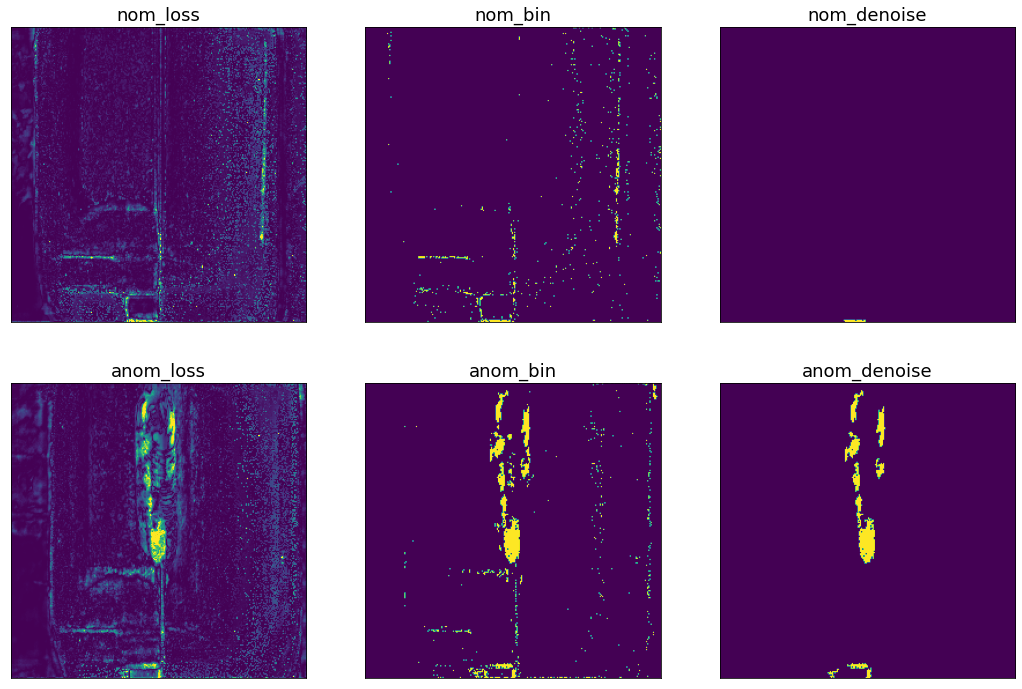

In [363]:
# Select images to demo in this notebook
nominal_index = random.randrange(0, len(train_images))
print(f"nominal_index: {nominal_index}")
nominal_img = train_images[nominal_index]

anomalous_index = random.randrange(0, len(unfit_images))
print(f"anomalous_index: {anomalous_index}")
anomalous_img = unfit_images[anomalous_index]

###########################################################################


pred_nom_img = predict(model, nominal_img)
nom_loss = find_loss_image(nominal_img, pred_nom_img)
nom_bin = binarize(nom_loss, thresh)
nom_denoise = denoise(nom_bin, min_pixels_per_cluster)

pred_anom_img = predict(model, anomalous_img)
anom_loss = find_loss_image(anomalous_img, pred_anom_img)
anom_bin = binarize(anom_loss, thresh)
anom_denoise = denoise(anom_bin, min_pixels_per_cluster)

###########################################################################

image_grid = [[nom_loss*15., nom_bin, nom_denoise],
              [anom_loss*15., anom_bin, anom_denoise]]

label_grid = [["nom_loss", "nom_bin", "nom_denoise"],
              ["anom_loss", "anom_bin", "anom_denoise"]]

print("Loss on trained image: %0.4f" %  np.mean(nom_denoise))
print("Loss on unfit image: %0.4f" % np.mean(anom_denoise))
print(f"{v}: Unfit image missed %0.2f times as much information." % (np.mean(anom_denoise)/np.mean(nom_denoise)) ) 
    
show_image_grid(image_grid, label_grid, intensity_range=(0, 1)) 
print(np.max(nom_loss))

# TODO
Add a set of images for nom and anom showing
- loss image
- Thresholded loss image
- Thresholded loss image with denoising

# Show extracted pixels overlaid on top of original

Loss on trained image: 0.0005
Loss on unfit image: 0.0181
Unfit image missed 33.89 times as much information.


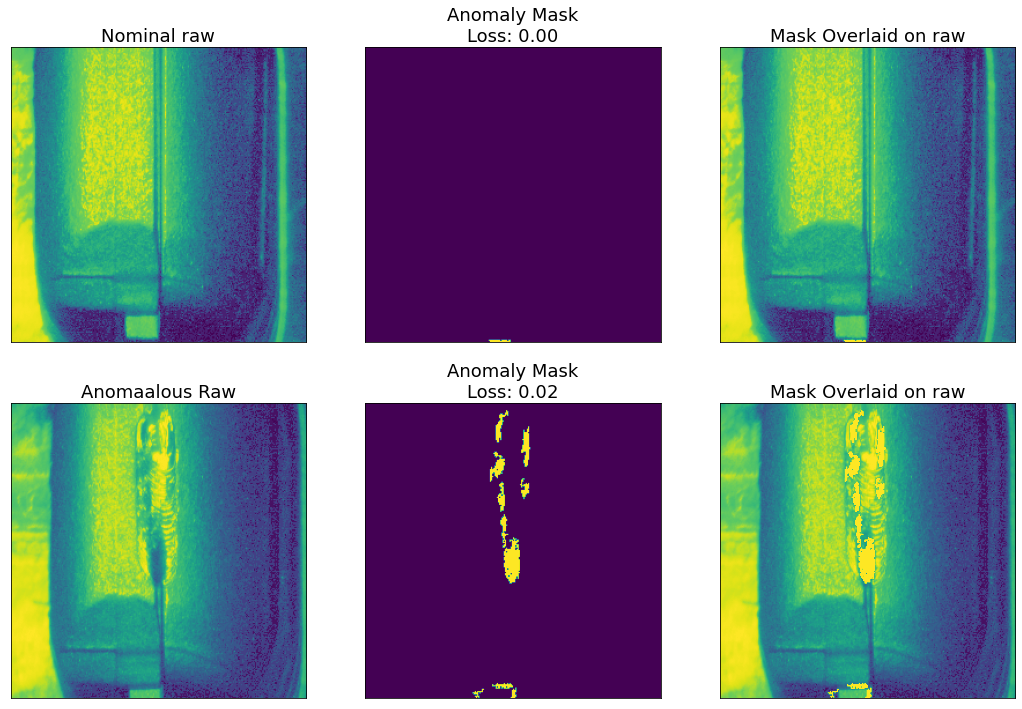

In [364]:
post_nom_im = post_process(nominal_img, pred_nom_img, thresh, min_pixels_per_cluster)
post_anom_im = post_process(anomalous_img, pred_anom_img, thresh, min_pixels_per_cluster)

# print(post_trained_im[0].shape)
trained_mean_loss = np.mean(post_nom_im)
anomalous_mean_loss = np.mean(post_anom_im)

image_grid = [[nominal_img, post_nom_im, nominal_img+post_nom_im],
              [anomalous_img, post_anom_im, anomalous_img+post_anom_im]]

label_grid = [["Nominal raw", "Anomaly Mask\nLoss: %0.2f" % trained_mean_loss, "Mask Overlaid on raw"],
             ["Anomaalous Raw", "Anomaly Mask\nLoss: %0.2f" % anomalous_mean_loss, "Mask Overlaid on raw"]]

print("Loss on trained image: %0.4f" % trained_mean_loss)
print("Loss on unfit image: %0.4f" % anomalous_mean_loss)
print("Unfit image missed %0.2f times as much information." % (anomalous_mean_loss/trained_mean_loss) ) 

show_image_grid(image_grid, label_grid, intensity_range=(0, 1)) 


# Summary and Analysis (Averaged over entire dataset)

In [386]:
# Todo: Write a method that uses the underlying numpy vectorization (this one expands into lists, and then vectorizes
# python lists, which is still fairly slow

In [387]:
def process_images(pre_images):
    kernel_dims = (3,3)
    print("pre_images (adjusted): ", np.expand_dims(train_images, -1).shape)
    pred_images = model.predict(pre_images)
    print("pred_nom_images: ", pred_nom_images.shape)
    loss_nom_images = tf.losses.mean_squared_error( np.expand_dims(pre_images, -1), pred_images).numpy()
    print("loss_nom_images: ", loss_nom_images.shape)
    bin_nom_images = np.array([binarize(image, thresh) for image in loss_nom_images])
    print("bin_nom_images: ", bin_nom_images.shape)
    denoise_images = np.array([remove_salt_and_pepper_noise(image, kernel_dims) for image in bin_nom_images])
    print("denoise_images ", denoise_images.shape)
    mean_loss = np.mean(denoise_images, (1,2))
    print("Complete\n")
    return mean_loss 

                              
train_loss_list = process_images(train_images)  
anomaly_loss_list = process_images(unfit_images)

pre_images (adjusted):  (147, 256, 256, 1)
pred_nom_images:  (149, 256, 256, 1)
loss_nom_images:  (147, 256, 256)
bin_nom_images:  (147, 256, 256)
denoise_images  (147, 256, 256)
Complete

pre_images (adjusted):  (147, 256, 256, 1)
pred_nom_images:  (149, 256, 256, 1)
loss_nom_images:  (146, 256, 256)
bin_nom_images:  (146, 256, 256)
denoise_images  (146, 256, 256)
Complete



# Average the value over each filtered image and plot

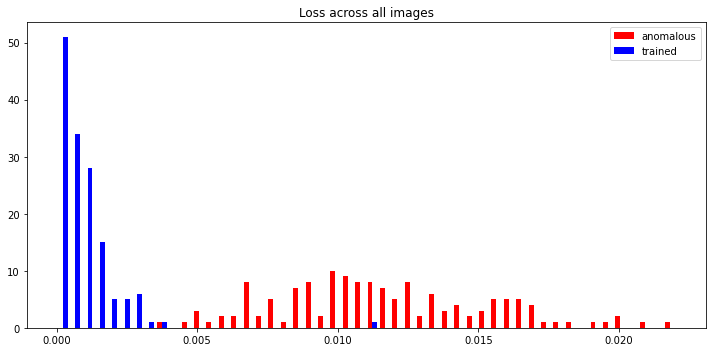

Bad Nominal:  0.011077881 : 48
Bad Nominal:  0.0037841797 : 112
Bad Nominal:  0.0033569336 : 144


In [388]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = axes # ax = axes.flatten()

data = [anomaly_loss_list, train_loss_list]
bins = 50
colors = ['red','blue']
labels = ["anomalous", "trained"]
ax.hist(data, bins, histtype='bar', color=colors, label=labels)

ax.set_title('Loss across all images')
ax.legend(prop={'size': 10})
fig.tight_layout()

plt.show()
bad_image_thresh = 0.003
for i, v in enumerate(train_loss_list):
    if v > bad_image_thresh:
        print("Bad Nominal: ", v, ":", i)
for i, v in enumerate(anomaly_loss_list):
    if v < bad_image_thresh: 
        print("Bad anomalous: ", v, ":", i)

### Overall, we have 2 distinct distributions, which is great!
- They do bleed into each other, which isn't great, but using a conservative threshold (.003, we can catch everything). In a real production situation, I'd lower the threshold further, since any escapes (false negatives) are far more critical than false positives, which just require an operator to manually inspect the item. This is not ready for production yet, mand my traditional computer vision program (using Cognex) does perform better. However, considering this is a first pass, uses very little data, and generalizes to different data sets, this definitely seems like a viable approach to explore further.
- Clearly, this is not Gaussian, so there's no point in finding Cpk/Ppk. We'd need to do a little more work to understand this distribution and validate this in a way that would satisfy regulatory.
 